El propósito de este Notebook es probar los mejores parámetros encontrados para los modelos. El entrenamiento de los modelos se realiza en Azure

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import numpy as np

import plotly.graph_objects as go

## Cargar datos

In [3]:
df = pd.read_parquet('../Datos/df_modelo.parquet')

### Revisar datos faltantes e imputar por la media

In [4]:
def find_missing_dates(df, fecha_col, valor_col, fecha_inicio, fecha_fin):
    '''
    Argumentos:
    
    df: nombre del dataframe
    fecha_col: nombre de la columna con la fechas: 'fecha_col'
    valor_col: nombre de la columna con los valores: 'valor_col
    fecha_inicio: fecha de inicio '2019-01-01'
    fecha_fin: fecha de finalización '2022-12-31'
    '''
    # Fechas de inicio y fin estén en formato datetime
    fecha_inicio = pd.to_datetime(fecha_inicio)
    fecha_fin = pd.to_datetime(fecha_fin)

    # Crea un dataframe completo con todas las fechas en el rango
    fechas = pd.date_range(start=fecha_inicio, end=fecha_fin)
    df_completo = pd.DataFrame(fechas, columns=[fecha_col])

    # Fusiona el dataframe completo con el dataframe original
    df_merged = pd.merge(df_completo, df, how='left', on=fecha_col)

    # Encuentra las fechas para las que falta el valor
    fechas_faltantes = df_merged[df_merged[valor_col].isnull()][fecha_col]

    return fechas_faltantes

In [5]:
def add_missing_dates(df, fecha_col, valor_col, fecha_inicio, fecha_fin):
    '''
    Argumentos:
    
    df: nombre del dataframe
    fecha_col: nombre de la columna con la fechas: 'fecha_col'
    valor_col: nombre de la columna con los valores: 'valor_col
    fecha_inicio: fecha de inicio '2019-01-01'
    fecha_fin: fecha de finalización '2022-12-31'
    '''
    # Fechas de inicio y fin estén en formato datetime
    fecha_inicio = pd.to_datetime(fecha_inicio)
    fecha_fin = pd.to_datetime(fecha_fin)

    # Crea un dataframe completo con todas las fechas en el rango
    fechas = pd.date_range(start=fecha_inicio, end=fecha_fin)
    df_completo = pd.DataFrame(fechas, columns=[fecha_col])

    # Calcula el valor medio
    mean_val = df[valor_col].mean()

    # Fusiona el dataframe completo con el dataframe original
    df_merged = pd.merge(df_completo, df, how='left', on=fecha_col)

    # Rellena los valores faltantes con el valor medio
    df_merged[valor_col] = df_merged[valor_col].fillna(mean_val)

    return df_merged


In [6]:
fechas_faltantes = find_missing_dates(
    df=df,
    fecha_col='fecha_creacion',
    valor_col='numero_de_usuarios',
    fecha_inicio='2019-01-01',
    fecha_fin='2022-12-31'
)

In [7]:
fechas_faltantes

12    2019-01-13
20    2019-01-21
53    2019-02-23
96    2019-04-07
403   2020-02-08
404   2020-02-09
991   2021-09-18
Name: fecha_creacion, dtype: datetime64[ns]

In [8]:
df_modelo = add_missing_dates(
    df=df,
    fecha_col='fecha_creacion',
    valor_col='numero_de_usuarios',
    fecha_inicio='2019-01-01',
    fecha_fin='2022-12-31'
)

In [9]:
df_modelo

,fecha_creacion,numero_de_usuarios
0,2019-01-01,1.0
1,2019-01-02,12.0
2,2019-01-03,19.0
3,2019-01-04,14.0
4,2019-01-05,3.0
...,...,...
1456,2022-12-27,47.0
1457,2022-12-28,38.0
1458,2022-12-29,43.0
1459,2022-12-30,26.0


In [10]:
df_modelo.set_index('fecha_creacion', inplace=True)

In [11]:
df_modelo

,numero_de_usuarios
fecha_creacion,
2019-01-01,1.0
2019-01-02,12.0
2019-01-03,19.0
2019-01-04,14.0
2019-01-05,3.0
...,...
2022-12-27,47.0
2022-12-28,38.0
2022-12-29,43.0


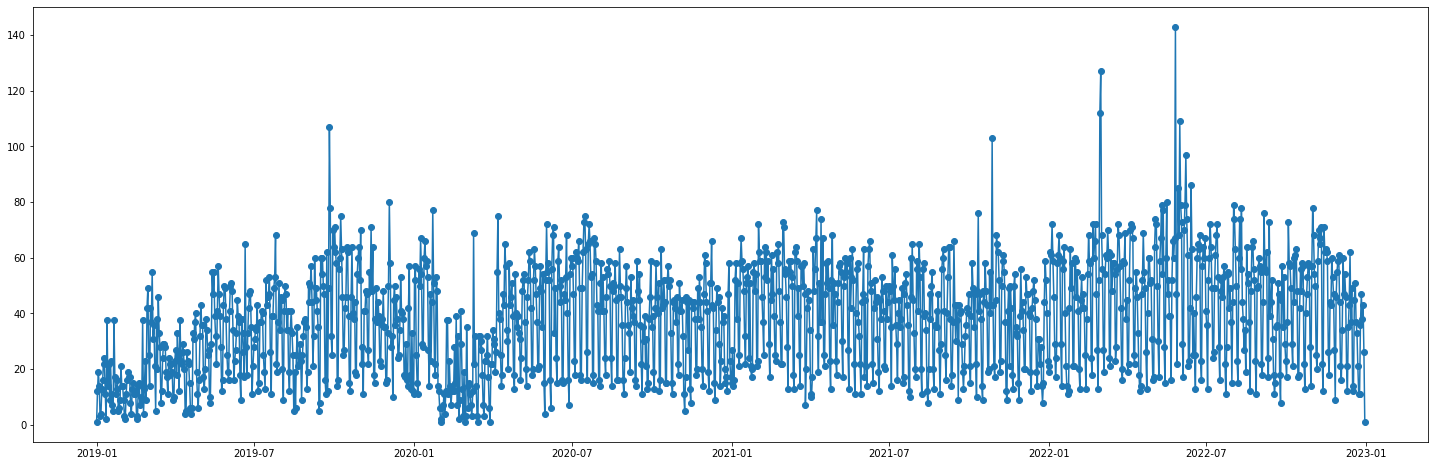

In [12]:
plt.figure(figsize=(25,8))
plt.plot(df_modelo, marker='o')
plt.show()

In [13]:
df_modelo_2 = df_modelo.loc['2022-01-01':]

In [14]:
df_modelo_2

,numero_de_usuarios
fecha_creacion,
2022-01-01,19.0
2022-01-02,21.0
2022-01-03,62.0
2022-01-04,61.0
2022-01-05,72.0
...,...
2022-12-27,47.0
2022-12-28,38.0
2022-12-29,43.0


## Train - Test Split

In [15]:
# Train-Test split

num_pron = 31
train, test = df_modelo_2[:-num_pron], df_modelo_2[-num_pron:] 

In [16]:
# Crea el gráfico
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train['numero_de_usuarios'], mode='lines+markers', name='train'))
fig.add_trace(go.Scatter(x=test.index, y=test['numero_de_usuarios'], mode='lines+markers', name='test'))
fig.update_layout(title = 'Train-Test Data', autosize = False, width = 1500, height = 600)
fig.show()

# Holt-Winters

## H-W Model

Mejor Modelo en Azure # 1

In [17]:
best_model_1 = {
    'trend': 'mul',
    'damped': True,
    'seasonal': 'add',
    'seasonal_periods': 7,
    'remove_bias': True,
    'smoothing_level': 0.5,
    'smoothing_slope': 0.0,
    'smoothing_seasonal': 0.0,
    'damping_slope': 0.0
    }

In [18]:
# Best Model Creation

model = ExponentialSmoothing(
    train,
    trend = best_model_1['trend'],
    damped = best_model_1['damped'],
    seasonal = best_model_1['seasonal'],
    seasonal_periods = best_model_1['seasonal_periods']    
)

model_fit = model.fit(
    remove_bias = best_model_1['remove_bias'],
    smoothing_level = best_model_1['smoothing_level'],
    smoothing_slope = best_model_1['smoothing_slope'],
    smoothing_seasonal = best_model_1['smoothing_seasonal'],
    damping_slope = best_model_1['damping_slope']
)

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [19]:
predictions = model_fit.predict(start='2022-12-01', end='2022-12-31')

In [29]:
def eval_pronosticos(real, forecast):
  
  # # Convertimos las entradas a arreglos de numpy para asegurarnos de que los cálculos se realizan correctamente
  real = np.array(real)
  forecast = np.array(forecast)

    
  # Calculamos los errores cuadráticos medios (RMSE)
  rmse = np.sqrt(mean_squared_error(real, forecast))
        
  # Calculamos el error absoluto medio (MAE)
  mae = mean_absolute_error(real, forecast)
  
  # Calculamos el MAPE
  mape = np.mean(np.abs((real - forecast) / real))*100
  
  # Calculamos MAPE acumulado
  real_sum = real.sum()
  forecast_sum = forecast.sum()
  mape_acum = np.abs((real_sum - forecast_sum) / real_sum)*100
    
    
  #Imprimir los resultados  
  print('RMSE: ', rmse)
  print('MAE: ', mae)
  print('MAPE: ', mape )
  print('MAPE Acum: ', mape_acum)

In [21]:
# Predictions and test values
predictions_df = pd.DataFrame(index=test.index)
predictions_df['Valores_Reales'] = test.values
predictions_df['Predicciones'] = predictions

In [23]:
r = np.array(predictions_df['Valores_Reales'])

In [24]:
print(r.sum())

1068.0


In [23]:
predictions_df

,Valores_Reales,Predicciones
fecha_creacion,,
2022-12-01,61.0,52.994964
2022-12-02,44.0,47.888573
2022-12-03,21.0,20.664282
2022-12-04,16.0,11.643445
2022-12-05,34.0,44.601800
2022-12-06,60.0,55.830953
2022-12-07,47.0,58.310101
2022-12-08,54.0,52.994964
2022-12-09,46.0,47.888573


In [30]:
eval_pronosticos(predictions_df.Valores_Reales, predictions_df.Predicciones)

RMSE:  11.630524114862851
MAE:  8.82334784948875
MAPE:  91.66311197458774
MAPE Acum:  20.719503193193226


In [22]:
# Crea el gráfico
fig = go.Figure()
fig.add_trace(go.Scatter(x=predictions_df.index, y=predictions_df['Valores_Reales'], mode='lines+markers', name='Valores Reales'))
fig.add_trace(go.Scatter(x=predictions_df.index, y=predictions_df['Predicciones'], mode='lines+markers', name='Predicciones'))
fig.update_layout(title='Forecast Baseline Model',autosize = False, width = 1500, height = 600)
fig.show()

Mejor Modelo en Azure # 2

In [31]:
best_model_2 = {
    'trend': 'add',
    'damped': True,
    'seasonal': 'add',
    'seasonal_periods': 7,
    'remove_bias': True,
    'smoothing_level': 0.03,
    'smoothing_slope': 0.5700000000000001,
    'smoothing_seasonal': 0,
    'damping_slope': 1
    }

In [32]:
# Best Model Creation

model = ExponentialSmoothing(
    train,
    trend = best_model_2['trend'],
    damped = best_model_2['damped'],
    seasonal = best_model_2['seasonal'],
    seasonal_periods = best_model_2['seasonal_periods']    
)

model_fit = model.fit(
    remove_bias = best_model_2['remove_bias'],
    smoothing_level = best_model_2['smoothing_level'],
    smoothing_slope = best_model_2['smoothing_slope'],
    smoothing_seasonal = best_model_2['smoothing_seasonal'],
    damping_slope = best_model_2['damping_slope']
)

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [33]:
predictions = model_fit.predict(start='2022-12-01', end='2022-12-31')

In [34]:
predictions_df = pd.DataFrame(index=test.index)
predictions_df['Valores_Reales'] = test.values
predictions_df['Predicciones'] = predictions

In [35]:
eval_pronosticos(predictions_df.Valores_Reales, predictions_df.Predicciones)

RMSE:  7.407098483150696
MAE:  6.519761131593834
MAPE:  29.29979403916593
MAPE Acum:  2.5676904779360807


In [36]:
# Crea el gráfico
fig = go.Figure()
fig.add_trace(go.Scatter(x=predictions_df.index, y=predictions_df['Valores_Reales'], mode='lines+markers', name='Valores Reales'))
fig.add_trace(go.Scatter(x=predictions_df.index, y=predictions_df['Predicciones'], mode='lines+markers', name='Predicciones'))
fig.update_layout(title='Forecast Baseline Model',autosize = False, width = 1500, height = 600)
fig.show()